In [2]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import casadi as ca
import pandas as pd

In [5]:
# 1. set file path
file_path = "../Laptimeoptimization/Monza.csv"

# 2. read csv file
df = pd.read_csv(file_path)

# 3. look head
print(df.head())

# 4. rename the first row
##df.rename(columns={'# x_m': 'x_m'}, inplace=True)

# 5. read the columns
x = df['# x_m'].values
y = df['y_m'].values
w_left = df['w_tr_left_m'].values
w_right = df['w_tr_right_m'].values

      # x_m        y_m  w_tr_right_m  w_tr_left_m
0 -0.320123   1.087714         5.739        5.932
1  0.168262   6.062191         5.735        5.929
2  0.656139  11.036647         5.731        5.926
3  1.143549  16.011082         5.727        5.923
4  1.630535  20.985493         5.723        5.920


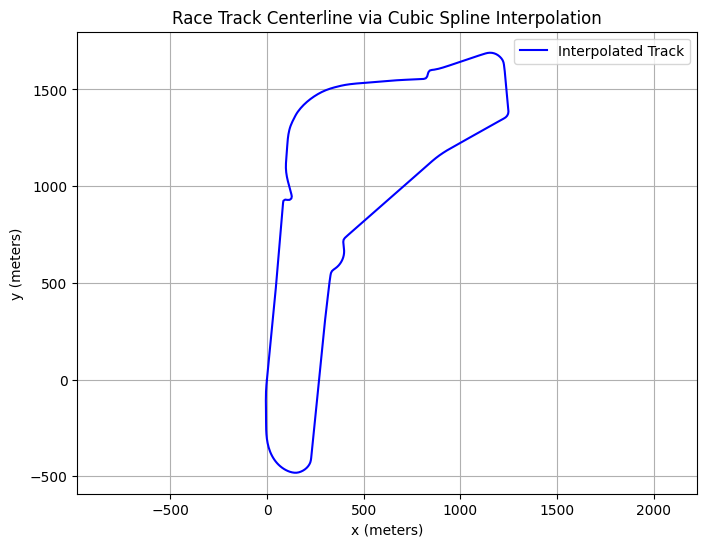

In [6]:
# Step 1: Compute arclengths
s = np.zeros(len(x))
s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
s_max=s[-1] #the length of the track

# Step 2: Create cubic spline interpolators
x_spline = CubicSpline(s, x)
y_spline = CubicSpline(s, y)

# Step 3: Get the first and second derivative of the parameteriation
dx_ds = x_spline.derivative(1)
d2x_ds2 = x_spline.derivative(2)
dy_ds = y_spline.derivative(1)
d2y_ds2 = y_spline.derivative(2)

## Generate interpolated values for plotting
s_query = np.linspace(0, s_max, 500)
x_interp = x_spline(s_query)
y_interp = y_spline(s_query)

## Plot the spline
plt.figure(figsize=(8, 6))
plt.plot(x_interp, y_interp, label='Interpolated Track', color='blue')
##plt.plot(x, y, 'ro', label='Original Points')
plt.axis('equal')
plt.title('Race Track Centerline via Cubic Spline Interpolation')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.legend()
plt.grid(True)
plt.show()

# output parameterisation and curvature as a casadi instance
x_ref = ca.interpolant('x_ref', 'linear', [s_query], x_interp)
y_ref = ca.interpolant('y_ref', 'linear', [s_query], y_interp)
kappa_ref_ = dx_ds(s_query)*d2y_ds2(s_query)-dy_ds(s_query)*d2x_ds2(s_query)
kappa_ref = ca.interpolant('kappa', 'linear', [s_query], kappa_ref_)

In [ ]:
# ----------------------------------------------------------------------
# ============       PARAMETERS (easy to tune)        ==================
# ----------------------------------------------------------------------
ANG_MIN_DEG   = 3.0          # θ candidates below this are ignored      (°)
CURV_MIN      = 5e-4         # |κ| below this is considered "straight" (1/m)
SLIDING_WIN   = 20.0         # sliding-max window length along s (m)
DENSE_STEP    = 0.5          # dense sampling step for boundaries (m)
DELTA_S       = 300.0        # forward window for FOV (m)

# ----------------------------------------------------------------------
# ============  Helper functions: boundary, extrema, FOV  ==============
# ----------------------------------------------------------------------
from typing import Tuple

def build_boundaries(spline_x, spline_y,
                     w_left: np.ndarray, w_right: np.ndarray,
                     s_dense: np.ndarray
                     ) -> Tuple[
                         Tuple[np.ndarray, np.ndarray],   # left (x,y)
                         Tuple[np.ndarray, np.ndarray],   # right (x,y)
                         Tuple[np.ndarray, np.ndarray],   # normal (nx,ny)
                         np.ndarray                       # tangent norm
                     ]:
    """Return dense left/right boundary samples and local normals."""
    xc = spline_x(s_dense)
    yc = spline_y(s_dense)

    dx = spline_x.derivative(1)(s_dense)
    dy = spline_y.derivative(1)(s_dense)
    norm_t = np.hypot(dx, dy)
    tx, ty = dx / norm_t, dy / norm_t
    nx, ny = -ty, tx                                    # left normal

    w_left_d  = np.interp(s_dense, s, w_left)
    w_right_d = np.interp(s_dense, s, w_right)

    xl = xc + nx * w_left_d
    yl = yc + ny * w_left_d
    xr = xc - nx * w_right_d
    yr = yc - ny * w_right_d
    return (xl, yl), (xr, yr), (nx, ny), norm_t


def first_crossing(s0: float, p_ray: np.ndarray,
                   center_x: np.ndarray, center_y: np.ndarray,
                   s_dense: np.ndarray) -> float:
    """Return the first s on the centreline hit by the ray; ∞ if none."""
    # Get index of the segment where s0 lives
    i0 = np.searchsorted(s_dense, s0)
    P0 = np.array([center_x[i0], center_y[i0]])          # ray anchor

    for i in range(i0, len(center_x) - 1):
        A = np.array([center_x[i],     center_y[i]])
        B = np.array([center_x[i + 1], center_y[i + 1]])
        v = B - A
        M = np.column_stack((p_ray, -v))                 # [ray | -segment]
        rhs = A - P0
        try:
            t, u = np.linalg.solve(M, rhs)
        except np.linalg.LinAlgError:
            continue                                    # parallel lines
        if t >= 0 and 0.0 <= u <= 1.0:
            return s_dense[i] + u * (s_dense[i + 1] - s_dense[i])
    return np.inf


def has_local_extreme(theta: np.ndarray) -> bool:
    """Early-exit monotonicity test with 3 ° dead-zone."""
    falling = None
    for prev, curr in zip(theta[:-1], theta[1:]):
        if abs(curr) < np.deg2rad(ANG_MIN_DEG):          # angle too small
            continue
        if prev == curr:
            continue
        trend = curr > prev                              # rising?
        if falling is None:
            falling = trend
        elif trend != falling:                           # slope changed
            return True
        falling = trend
    return False


def compute_fov_all(spline_x, spline_y,
                    w_left: np.ndarray, w_right: np.ndarray,
                    s_query: np.ndarray,
                    delta_s: float = DELTA_S,
                    step: float = DENSE_STEP) -> np.ndarray:
    """Compute sfov(s) for every point in s_query."""
    # --- dense grid along the whole track --------------------------------
    s_dense = np.arange(0, s_max + step, step)
    (xl, yl), (xr, yr), (nx, ny), _ = build_boundaries(
        spline_x, spline_y, w_left, w_right, s_dense)
    center_x = spline_x(s_dense)
    center_y = spline_y(s_dense)

    sfov_raw = np.empty_like(s_query)

    for k, s0 in enumerate(s_query):
        idx0 = np.searchsorted(s_dense, s0)
        idx_w = np.searchsorted(s_dense, s0 + delta_s, side='right')

        # wrap-around for circular track
        if idx_w >= len(s_dense):
            extra = idx_w - len(s_dense) + 1
            s_ext       = np.concatenate((s_dense, s_dense[1:extra] + s_max))
            xl_ext      = np.concatenate((xl, xl[1:extra]))
            yl_ext      = np.concatenate((yl, yl[1:extra]))
            xr_ext      = np.concatenate((xr, xr[1:extra]))
            yr_ext      = np.concatenate((yr, yr[1:extra]))
            center_xext = np.concatenate((center_x, center_x[1:extra]))
            center_yext = np.concatenate((center_y, center_y[1:extra]))
        else:
            s_ext       = s_dense
            xl_ext, yl_ext = xl, yl
            xr_ext, yr_ext = xr, yr
            center_xext, center_yext = center_x, center_y

        # --- vehicle heading vector at s0 --------------------------------
        tx0 = spline_x.derivative(1)(s0)
        ty0 = spline_y.derivative(1)(s0)
        dir_vec = np.array([tx0, ty0]) / np.hypot(tx0, ty0)

        # --- helper to compute θ sequence --------------------------------
        def theta_arr(xb, yb):
            Vx = xb[idx0:idx_w] - spline_x(s0)
            Vy = yb[idx0:idx_w] - spline_y(s0)
            cross = dir_vec[0] * Vy - dir_vec[1] * Vx
            dot   = dir_vec[0] * Vx + dir_vec[1] * Vy
            theta = np.arctan2(cross, dot)
            # filter small |θ| here (ANG_MIN)
            mask  = np.abs(theta) >= np.deg2rad(ANG_MIN_DEG)
            return theta[mask], Vx[mask], Vy[mask]

        θL, VLx, VLy = theta_arr(xl_ext, yl_ext)
        θR, VRx, VRy = theta_arr(xr_ext, yr_ext)

        has_ext_L = has_local_extreme(θL)
        has_ext_R = has_local_extreme(θR)

        # --- curvature-based straight-road filter ------------------------
        kappa_now = (spline_x.derivative(1)(s0) * spline_y.derivative(2)(s0)
                     - spline_y.derivative(1)(s0) * spline_x.derivative(2)(s0))
        if abs(kappa_now) < CURV_MIN:
            # small curvature: treat as straight
            sfov_raw[k] = s0 + delta_s
            continue

        # if both sides miss extrema within δs, also treat as straight
        if not has_ext_L and not has_ext_R:
            sfov_raw[k] = s0 + delta_s
            continue

        # --- choose rays --------------------------------------------------
        s_inner = np.inf
        s_outer = np.inf

        if kappa_now < 0:  # right turn ⇒ right side is inner
            if has_ext_R:
                idx_R = np.argmin(θR)            # most negative
                p_ray = np.array([VRx[idx_R], VRy[idx_R]])
                p_ray /= np.linalg.norm(p_ray)
                s_inner = first_crossing(s0, p_ray, center_xext, center_yext, s_ext)
            if has_ext_L:
                idx_L = np.argmax(θL)            # largest positive
                p_ray = np.array([VLx[idx_L], VLy[idx_L]])
                p_ray /= np.linalg.norm(p_ray)
                s_outer = first_crossing(s0, p_ray, center_xext, center_yext, s_ext)
        else:            # left turn
            if has_ext_L:
                idx_L = np.argmax(θL)
                p_ray = np.array([VLx[idx_L], VLy[idx_L]])
                p_ray /= np.linalg.norm(p_ray)
                s_inner = first_crossing(s0, p_ray, center_xext, center_yext, s_ext)
            if has_ext_R:
                idx_R = np.argmin(θR)
                p_ray = np.array([VRx[idx_R], VRy[idx_R]])
                p_ray /= np.linalg.norm(p_ray)
                s_outer = first_crossing(s0, p_ray, center_xext, center_yext, s_ext)

        sfov_raw[k] = min(s_inner, s_outer)

    # ------------------------------------------------------------------
    # Sliding-maximum filter: ensure sfov is non-decreasing
    # ------------------------------------------------------------------
    win = int(SLIDING_WIN / (s_query[1] - s_query[0]))  # window size in samples
    sfov_filt = np.copy(sfov_raw)
    running_max = sfov_raw[0]
    for i in range(len(sfov_raw)):
        running_max = max(running_max, sfov_raw[i])
        if i > win:
            running_max = max(sfov_raw[i - win:i + 1])
        sfov_filt[i] = running_max
    return sfov_filt

In [7]:
sfov_vals = compute_fov_all(
    x_spline, y_spline, w_left, w_right,
    s_query, delta_s=DELTA_S)

sfov_ca = ca.interpolant('sfov', 'linear', [s_query], sfov_vals)

NameError: name 'compute_fov_all' is not defined

In [ ]:
# ---------- save_fov_to_csv.py ----------
import os
import pandas as pd

def save_sfov_csv(s_samples, sfov_samples,
                  in_csv_path: str,
                  out_name: str = "sfov_lookup.csv") -> str:
    """
    Save (s, sfov) pairs to a CSV file in the same folder as the input track.

    Parameters
    ----------
    s_samples     : 1-D array-like, arc-length samples.
    sfov_samples  : 1-D array-like, corresponding look-ahead values.
    in_csv_path   : str, path of the original track CSV (e.g. 'Monza.csv').
    out_name      : str, filename for the lookup table (default 'sfov_lookup.csv').

    Returns
    -------
    full_path     : str, absolute path of the written CSV file.
    """
    # build DataFrame
    df_out = pd.DataFrame({
        "s_m"   : s_samples,
        "sfov_m": sfov_samples
    })

    # decide output directory = same folder as input file
    out_dir = os.path.dirname(os.path.abspath(in_csv_path))
    full_path = os.path.join(out_dir, out_name)

    # write CSV (no index column)
    df_out.to_csv(full_path, index=False)
    print(f"[INFO] sfov table saved to: {full_path}")

    return full_path


# === example call ===
_ = save_sfov_csv(s_query, sfov_vals, file_path)

In [ ]:
# ---------- sfov_interpolant.py ----------
from typing import Union, Callable
import numpy as np
from scipy.interpolate import CubicSpline

def build_sfov_interpolant(s_nodes: np.ndarray,
                           sfov_nodes: np.ndarray,
                           extrapolate: bool = True
                           ) -> Callable[[Union[float, np.ndarray]], np.ndarray]:
    """
    Create a C²-continuous cubic-spline interpolant sfov(s).

    Parameters
    ----------
    s_nodes     : 1-D ndarray, strictly increasing arc-length samples.
    sfov_nodes  : 1-D ndarray, same length, sfov at each sample.
    extrapolate : bool, default True, allow evaluation outside domain.

    Returns
    -------
    sfov_fun    : callable, use like  sfov_fun(s_eval)  →  sfov value(s).
    """
    # Natural BC: second derivative = 0 at both ends
    cs = CubicSpline(s_nodes, sfov_nodes,
                     bc_type="natural",
                     extrapolate=extrapolate)

    def sfov_fun(s_eval: Union[float, np.ndarray]) -> np.ndarray:
        """Vectorised wrapper around CubicSpline."""
        return cs(s_eval)

    return sfov_fun


# === example call & usage ===
sfov_fun = build_sfov_interpolant(s_query, sfov_vals)
print("sfov(123.4 m) =", float(sfov_fun(123.4)))